In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.UNET import UNet2D

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [3]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 1000
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
alphas_bar_sqrt[-1] = 0
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_sqrt[-1] = 1


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [4]:
BATCH_SIZE = 1024


class QX:
    def __init__(self, time_step=None):
        self.ts = time_step

    def __call__(self, sample):
        return q_x(sample, torch.tensor(self.ts))


transform = transforms.Compose([
    transforms.ToTensor(),
    QX([i * 100 for i in range(10)] + [998, 999])
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

(array([20.37479286,  0.09346236,  0.18692471,  0.15577056,  0.15577062,
         0.06230825,  0.12461645,  0.18692467,  0.0934624 ,  0.12461645,
         0.03115411,  0.        ,  0.03115411,  0.09346234,  0.09346247,
         0.21807878,  0.12461645,  0.06230822,  0.09346234,  0.09346234,
         0.09346234,  0.24923326,  0.24923289,  0.24923289,  1.18385625]),
 array([-0.01550964,  0.02543231,  0.06637425,  0.1073162 ,  0.14825815,
         0.18920009,  0.23014203,  0.27108398,  0.31202593,  0.35296786,
         0.39390981,  0.43485177,  0.47579372,  0.51673567,  0.55767763,
         0.59861952,  0.63956147,  0.68050343,  0.72144538,  0.76238734,
         0.80332929,  0.84427124,  0.88521314,  0.92615509,  0.96709704,
         1.008039  ]),
 <BarContainer object of 25 artists>)

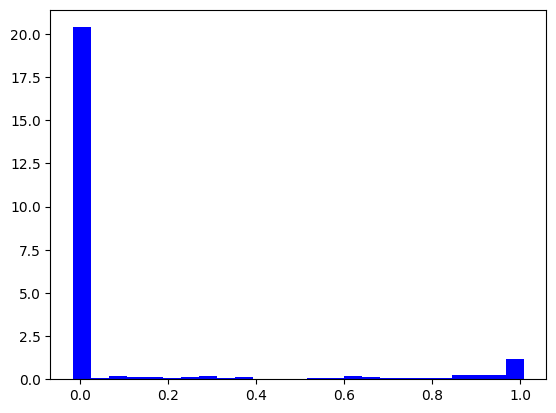

In [5]:
img0 = next(iter(train_loader))[0][0]
plt.hist(img0[0].flatten(), bins=25, density=True, color='b')

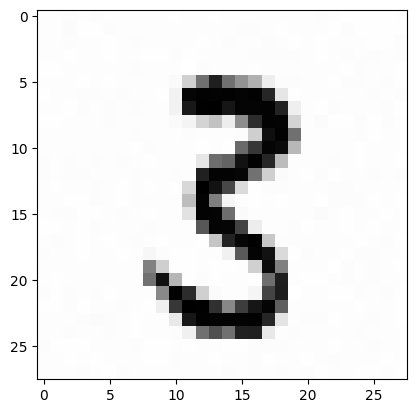

In [6]:
plt.imshow(img0[0], cmap='Greys')

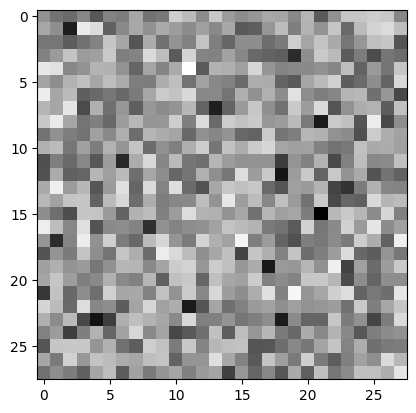

In [7]:
plt.imshow(img0[-1], cmap='Greys')

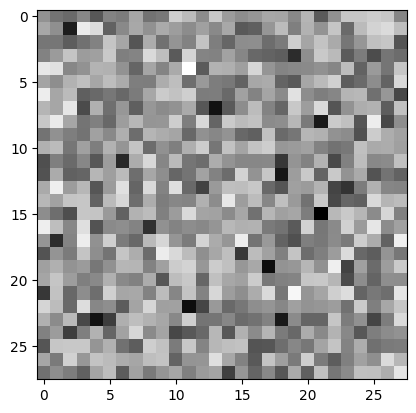

In [8]:
plt.imshow(img0[-2], cmap='Greys')

In [9]:
class TimestepLike(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size * 2)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hiddenSize = hidden_size

    def forward(self, X):
        h0 = self.encoder(X)
        h1, h2 = torch.chunk(h0, 2, dim=-1)
        h = torch.mul(h1, torch.softmax(h2, dim=-1))
        return self.decoder(nn.functional.leaky_relu(h))


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = TimestepLike(28 * 28, 256)
        self.mu = TimestepLike(256, 28 * 28)
        self.var = TimestepLike(256, 28 * 28)
        self.decoder = nn.Sequential(nn.Linear(28 * 28, 256),
                                     nn.LeakyReLU(),
                                     nn.Linear(256, 28 * 28))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, X):
        h = self.h(X)
        mu = self.mu(h)
        var = self.var(h)
        return self.decoder(self.reparameterize(mu, var))

In [10]:
# model = nn.Sequential(nn.Linear(28 * 28, 8 * 28),
#                       nn.ReLU(),
#                       # nn.Linear(256, 128),
#                       # nn.ReLU(),
#                       # nn.Linear(128, 256),
#                       # nn.ReLU(),
#                       nn.Linear(8 * 28, 28 * 28)).to('cuda')
# model = nn.Linear(28 * 28, 28 * 28).to('cuda')
model = UNet2D(1, 1).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=False, threshold=1e-3)

In [11]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            X = data[:, -1].to('cuda').view(-1, 1, 28, 28)
            Y = data[:, -2].to('cuda').view(-1, 1, 28, 28)
            optimizer.zero_grad()
            output = model(X)
            loss = L2Loss(output, Y)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.8f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss

In [12]:
for epoch in range(1, 1001):
    loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 81%|████████▏ | 48/59 [00:14<00:03,  3.22batch/s,  Epoch: 77 	Loss: 0.00539158	 lr: 0.00100000]


KeyboardInterrupt: 

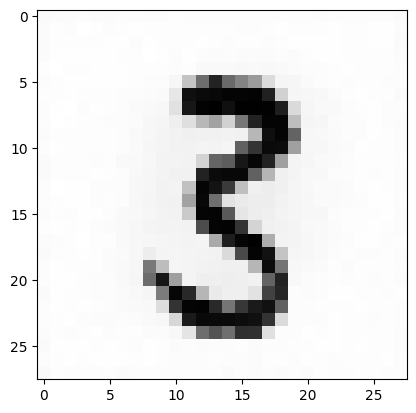

In [25]:
y = model(img0.to('cuda').view(-1, 1, 28, 28))
plt.imshow(y[0].cpu().detach().view(28, 28), cmap='Greys')

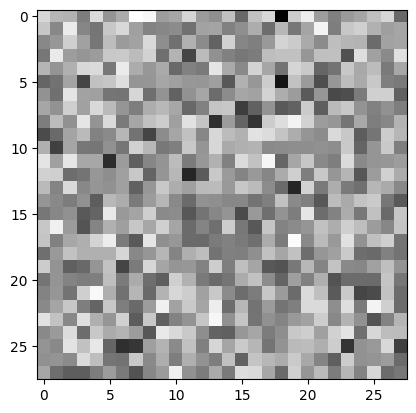

In [30]:
z = torch.randn_like(img0)
y = model(z.to('cuda').view(-1, 1, 28, 28))
plt.imshow(y[0].cpu().detach().view(28, 28), cmap='Greys')

(array([ 0.37296776,  0.22378085,  0.29837447,  0.29837447,  0.82052979,
         0.82052908,  1.79024682,  0.96971703,  1.34268394,  0.52215532,
         0.59674894,  0.59674868,  0.44756161,  0.37296801,  0.2983744 ,
         0.52215521, 30.43418927,  3.87886726,  2.98374405,  2.08862083,
         1.64105887,  2.46158937,  2.08862038,  1.4918717 ,  1.11890426]),
 array([-0.28071171, -0.26361224, -0.24651279, -0.22941333, -0.21231388,
        -0.19521442, -0.17811495, -0.1610155 , -0.14391604, -0.12681657,
        -0.10971712, -0.09261766, -0.0755182 , -0.05841874, -0.04131928,
        -0.02421982, -0.00712036,  0.0099791 ,  0.02707855,  0.04417801,
         0.06127747,  0.07837693,  0.09547639,  0.11257585,  0.12967531,
         0.14677477]),
 <BarContainer object of 25 artists>)

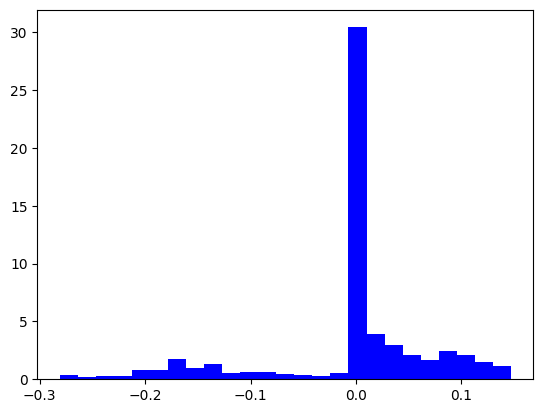

In [378]:
plt.hist((y.cpu().detach().view(28, 28) - img0[-2]).flatten(), bins=25, density=True, color='b')